In [1]:
!unzip glove.6B.50d.zip  # to extract word vectors

Archive:  glove.6B.50d.zip
  inflating: glove.6B.50d.txt        


In [19]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import os                                         # importing required libraries
import time
import numpy as np
import pandas as pd
import pickle as pkl
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout

In [20]:
def getVocab(filename,d_model): # to generate word-num-vector mapping using pre trained word vectors
    
    file = open(filename,'r')
    
    num     = 0
    vocab_num_to_vector = {}
    vocab_word_to_num   = {}
    vocab_num_to_vector[num] = np.zeros((d_model))
    vocab_word_to_num['ukn'] = num
    num+=1

    for lines in file:
        values = lines.split()
        word   = values[0]
        vector = list(map(float,values[1:]))
        vocab_num_to_vector[num] = np.array(vector)
        vocab_word_to_num[word]  = num
        num+=1
    
    return vocab_word_to_num,vocab_num_to_vector

In [21]:
def getData(filenames,delimiter):   # extract data from all the files
    
    reviews = []
    ratings = []
    
    for filename in filenames:
        
        file = open(filename,'r')
        
        for lines in file:
            values=lines.split(delimiter)
            reviews.append(values[0])
            ratings.append(int(values[-1]))

    data = list(zip(reviews,ratings))
    np.random.shuffle(data)
    reviews,ratings=zip(*data)

    reviews = np.array(reviews)
    ratings = np.array(ratings).reshape(-1,1).astype('float32')
    
    return reviews,ratings

In [22]:
def removePunctuations(word):   # removing non-alphabetic letters (punctuations and numbers)
    
    word       = list(word)
    clean_word = []
    
    for i in range(len(word)):
        
        if ord(word[i])>=97 and ord(word[i])<=122:
            clean_word.append(word[i])
            
    return ''.join(clean_word)

In [23]:
def cleanReviews(reviews,vocab_word_to_num):  # removing typoes and unknown words from reviews
    
    for i in range(len(reviews)):
        review  = reviews[i]
        words   = review.split()
        clean_review = []
        
        for word in words:
            word = word.lower()
            word = removePunctuations(word)
            if word not in vocab_word_to_num.keys():
                clean_review.append('ukn')
            else:
                clean_review.append(word)
        
        clean_review = ' '.join(clean_review)
        reviews[i]   = clean_review
        
    return reviews

In [24]:
def tokenize(reviews,vocab_word_to_num,max_len): # tokenizing the review statements 
    
    tokenized_reviews = np.zeros((len(reviews),max_len),dtype='int')
    
    for i in range(len(reviews)):
        review = reviews[i]
        review = review.split()
        for j in range(len(review)):
            tokenized_reviews[i][j] = vocab_word_to_num[review[j]]    
        
    return tokenized_reviews

In [25]:
def load_embd_matrix(vocab_num_to_vector,vocab_size,d_model):  # get the embedding matrix
    
    embd_matrix = np.zeros((vocab_size,d_model))
    
    for i in range(vocab_size):
        embd_matrix[i] = vocab_num_to_vector[i]
        
    return embd_matrix

In [26]:
def model_def(embd_matrix,vocab_size,d_model,max_len):  # define the model 
    
    model = Sequential()
    model.add(Embedding(vocab_size,d_model,weights=[embd_matrix],input_length=max_len,trainable=True,mask_zero=True))
    model.add(LSTM(200,dropout=0.5,kernel_regularizer=regularizers.l1_l2(l1=2e-5, l2=1e-4),bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(2e-5)))
    model.add(Dense(100, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-5, l2=1e-4),bias_regularizer=regularizers.l2(1e-4),activity_regularizer=regularizers.l2(2e-5)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [27]:
def trainModel():  # training the model
    vocab_word_to_num,vocab_num_to_vector = getVocab('glove.6B.50d.txt',50)
    reviews,ratings = getData(['amazon.txt','yelp.txt','imdb.txt'],'\t')
    reviews     = cleanReviews(reviews,vocab_word_to_num)
    reviews     = tokenize(reviews,vocab_word_to_num,100)
    embd_matrix = load_embd_matrix(vocab_num_to_vector,len(vocab_word_to_num),len(vocab_num_to_vector[0]))
    model       = model_def(embd_matrix,len(vocab_word_to_num),50,100)
    
    train_length= (int)(len(reviews)*0.9)
    x_train     = reviews[:train_length,:]
    x_test      = reviews[train_length:,:]
    y_train     = ratings[:train_length:,:]
    y_test      = ratings[train_length:,:]
    
    history     = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=256)
    
    return model,history
    

In [28]:
def plot(history):  # plotting the learning curve
    
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy and loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           20000050  
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               200800    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 20,221,051
Trainable params: 20,221,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
11/11 [==============================] - 8s 726ms/step - loss: 0.7822 - accuracy: 0.5648 - v

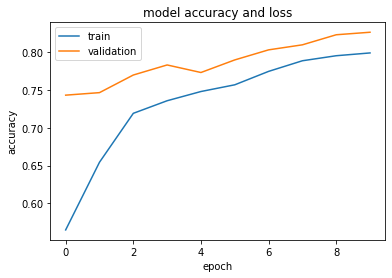

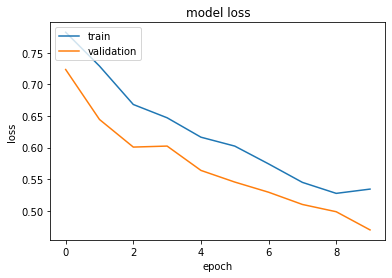

In [29]:
model,history = trainModel()
plot(history)

In [30]:
vocab_word_to_num,vocab_num_to_vector = getVocab('glove.6B.50d.txt',50)

review = "This project was fun"  # try a custom review
review = np.array([review])
review = cleanReviews(review,vocab_word_to_num)
review = tokenize(review,vocab_word_to_num,100)
print("Positive Review " if round(model.predict(review)[0][0],0) else "Negative Review ")

Positive Review 
